In [10]:

%load_ext autoreload
%autoreload 2
import random
import numpy as np
import itertools
from tqdm.notebook import tqdm

indices_used = list(itertools.product(itertools.permutations(range(4), 2), itertools.permutations(range(3), 2), itertools.permutations(range(2), 2)))
operations_used = list(itertools.product(range(4), repeat=3)) # 4 operations, using 3 at a time
operations = [
    lambda x, y: x + y,
    lambda x, y: x - y,
    lambda x, y: x * y,
    lambda x, y: x / y,
]
operation_names = ["+", "-", "*", "/"]
combos = list(itertools.product(indices_used, operations_used))

In [2]:
# filedata = {'MLPCrossEntropyModel': data}
import pickle

with open('data.pkl', 'rb') as file:
    filedata = pickle.load(file)
with open('data.pkl', 'wb') as file:
    pickle.dump(filedata, file)
# filedata

In [ ]:
from dataset import get_dataset, augment_data
from model import *
from sklearn.model_selection import train_test_split
_, solutions = get_dataset()
model = NNVariableWidth(hidden_dims=(256,256,256))
X, y = model.split_data(solutions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = augment_data(X_train, y_train, 4)
model.fit(X_train, y_train, num_epochs=200, tqdm=tqdm)

Epoch [1/200], Loss: 0.5526
Epoch [40/200], Loss: 0.5352
Epoch [80/200], Loss: 0.5350
Epoch [120/200], Loss: 0.5350
Epoch [160/200], Loss: 0.5350
Epoch [200/200], Loss: 0.5351


NNVariableWidth(
  (fcs): ModuleList(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1-2): 2 x Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=12, bias=True)
  )
)

In [27]:
# get accuracy on test
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, model.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)
mse_train, mse_test

(0.17763504321838056, 0.1774898843167528)

In [24]:
X_train[0], y_train[0], model.predict(X_train[0])

(array([ 8., 12.,  8.,  9.]),
 array([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
 array([0.24746068, 0.35930985, 0.17926303, 0.20532433, 0.27297578,
        0.22373547, 0.36641221, 0.13160391, 0.34080383, 0.27563122,
        0.19167127, 0.17125418]))

In [28]:
from tqdm.notebook import tqdm
import random
import numpy as np
use_random_weights = True
debug = False
use_random_list = False
min_probability = 0.2
def solve_with_model(x):
    # pair up two numbers 1-4, then 1-3, then 1-2.
    # For each pair, we can add, subtract, multiply or divide.

    target = 24
    choices = list(x)
    # shuffle it
    if use_random_weights:
        random.shuffle(choices)

    i = 0
    y = model.predict(x)
    # convert to 3x4
    if len(y) == 12:
        y = np.reshape(y, (3, 4))
    # y = model(torch.tensor(np.reshape(x, (1, -1)))).detach().numpy()[0]
    # y = model.predict_operation_probabilities(np.reshape(x, (1, -1)))[0]
    # if not separate_operation_indices:
    #     # separate them anyway
    #     y = np.tile(y, (3, 1))
    # apply a min probability on each operation
    y = np.maximum(y, min_probability)
    y = y / np.sum(y, axis=1)[:, np.newaxis]
    if debug:
        print(x, y)
    if use_random_list:
        random_index_combinations = list(itertools.product(itertools.permutations(range(4), 2), itertools.permutations(range(3), 2), itertools.permutations(range(2), 2)))
        random.shuffle(random_index_combinations)
        # sort the operations by probability
        sorted_operation_combinations = list(itertools.product(*(y.shape[1] - 1 - np.argsort(y))))
    while True:
        if use_random_list:
            index_first = True
            index_i = i % len(random_index_combinations) if index_first else i // len(sorted_operation_combinations)
            operation_i = i // len(random_index_combinations) if index_first else i % len(sorted_operation_combinations)
        index_order = random_index_combinations[index_i] if use_random_list else random.choice(indices_used)
        operation_order = sorted_operation_combinations[operation_i] if use_random_list else [random.choices(range(4), weights=y[op_index], k=1)[0] for op_index in range(3)]
        i += 1
        numbers = choices.copy()
        valid = True
        for (index1, index2), operation_index in zip(index_order, operation_order):
            val1 = numbers[index1]
            val2 = numbers[index2]
            numbers.pop(max(index1, index2))
            numbers.pop(min(index1, index2))
            if operation_index == 3 and val2 == 0:
                valid = False
                break
            numbers.append(operations[operation_index](val1, val2))
        if valid and numbers[0] == target:
            return True, index_order, operation_order, i
    return False, None, None, -1
def print_solution(numbers, index_order, operation_order, answer):
    terms = [str(x) for x in numbers]
    for (index1, index2), operation_index in zip(index_order, operation_order):
        term1 = terms[index1]
        term2 = terms[index2]
        terms.pop(max(index1, index2))
        terms.pop(min(index1, index2))
        new_term = f"({term1} {operation_names[operation_index]} {term2})"
        terms.append(new_term)
    print(" ".join(terms), "=", answer)
data = {}
for name, X_split, y_split in [("train", X_train, y_train), ("test", X_test, y_test)]:
    # if name == "train":
    #     continue
    print(name)
    counts = []
    for i in tqdm(range(len(X_split))):
        valid, index_order, operation_order, count = solve_with_model(X_split[i])
        if not valid:
            print("Failed to solve", X_split[i])
            break
        else:
            counts.append(count)
            if debug:
                print("input", X_split[i], "indices", index_order, "operations", operation_order, "count", i)
                print_solution(X_split[i], index_order, operation_order, 24)
                print()
                if i > 10:
                    break
    data[name] = counts
    print(name, "Average count", sum(counts) / len(counts)) # Train/Test 841.2078 / 766.814

train


  0%|          | 0/3372 [00:00<?, ?it/s]

train Average count 371.5717674970344
test


  0%|          | 0/211 [00:00<?, ?it/s]

test Average count 457.8009478672986


Split train had average count 366.37366548042706
Split test had average count 408.98578199052133


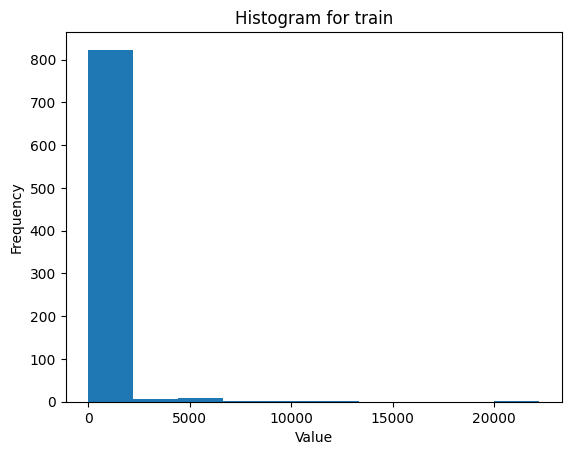

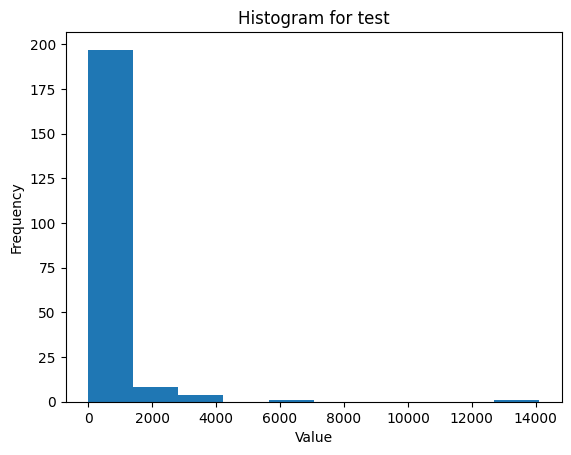

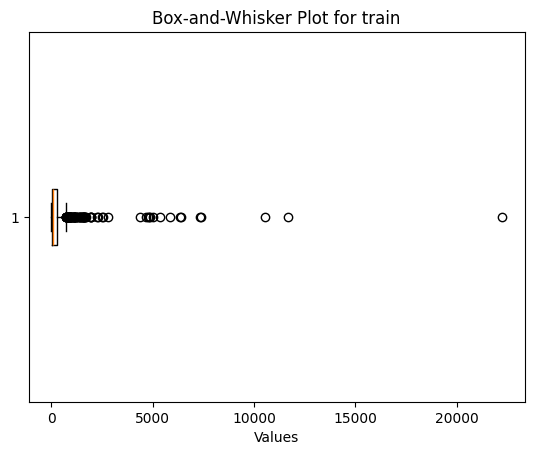

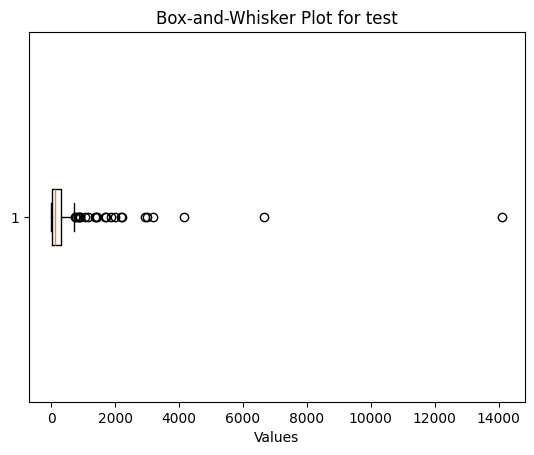

In [11]:
import matplotlib.pyplot as plt


for split in data.keys():
    print("Split", split, "had average count", sum(data[split]) / len(data[split]))
for split in data.keys():
    # Create the histogram
    plt.hist(data[split])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram for ' + split)
    plt.show()
for split in data.keys():
    # Display the histogram
    plt.boxplot(data[split],vert=False)
    plt.xlabel('Values')
    plt.title('Box-and-Whisker Plot for ' + split)
    plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
# Define the MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Outputs should be between 0 and 1
        return x
# Set the random seed for reproducibility
torch.manual_seed(42)
# Define the parameters
input_dim = 4
hidden_dim = 16
output_dim = 4
learning_rate = 0.01
num_epochs = 100
batch_size = 16
# Generate some dummy data for training
num_samples = 1000
Xfake = np.random.rand(num_samples, input_dim).astype(np.float32)  # Random input data
yfake = np.random.randint(0, 2, (num_samples, output_dim)).astype(np.float32)  # Random binary targets
print(X.shape, Xfake.shape)
print(y.shape, yfake.shape)
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)
# Create DataLoader for batching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Initialize the model, loss function, and optimizer
model = SimpleMLP(input_dim, hidden_dim, output_dim).double()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-attribute classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        # inputs = inputs.float()
        outputs = model(inputs)
        # Compute loss
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # Print the average loss for this epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
print("Training complete!")
# Test the model on a new sample
model.eval()

(1054, 4) (1000, 4)
(1054, 4) (1000, 4)
Epoch [1/100], Loss: 0.6434
Epoch [2/100], Loss: 0.6179
Epoch [3/100], Loss: 0.6094
Epoch [4/100], Loss: 0.6073
Epoch [5/100], Loss: 0.6026
Epoch [6/100], Loss: 0.6033
Epoch [7/100], Loss: 0.6019
Epoch [8/100], Loss: 0.6000
Epoch [9/100], Loss: 0.5982
Epoch [10/100], Loss: 0.5965
Epoch [11/100], Loss: 0.5962
Epoch [12/100], Loss: 0.5956
Epoch [13/100], Loss: 0.5938
Epoch [14/100], Loss: 0.5940
Epoch [15/100], Loss: 0.5927
Epoch [16/100], Loss: 0.5951
Epoch [17/100], Loss: 0.5930
Epoch [18/100], Loss: 0.5923
Epoch [19/100], Loss: 0.5911
Epoch [20/100], Loss: 0.5909
Epoch [21/100], Loss: 0.5917
Epoch [22/100], Loss: 0.5913
Epoch [23/100], Loss: 0.5909
Epoch [24/100], Loss: 0.5898
Epoch [25/100], Loss: 0.5891
Epoch [26/100], Loss: 0.5898
Epoch [27/100], Loss: 0.5902
Epoch [28/100], Loss: 0.5902
Epoch [29/100], Loss: 0.5894
Epoch [30/100], Loss: 0.5888
Epoch [31/100], Loss: 0.5901
Epoch [32/100], Loss: 0.5916
Epoch [33/100], Loss: 0.5892
Epoch [34/10

SimpleMLP(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
)

In [46]:
test_input = torch.tensor(X_test[0:3])
prediction = model(test_input)
print("Test Input:", test_input)
print("Prediction:", prediction)
print("Ground truth label:", y_test[0:3])
y_pred = model(torch.tensor(X_test)).detach().numpy()
accuracy = (np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)).sum().item() / (3 * 4)
mse = mean_squared_error(y_test, y_pred)
print(accuracy)
print(mse)

Test Input: tensor([[ 1.,  8.,  8., 11.],
        [ 8.,  8., 11., 12.],
        [ 4.,  9.,  9., 12.]], dtype=torch.float64)
Prediction: tensor([[0.6262, 0.6910, 0.7548, 0.3422],
        [0.6217, 0.7382, 0.6923, 0.4157],
        [0.6249, 0.7065, 0.7345, 0.3649]], dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)
Ground truth label: [[0. 1. 1. 1.]
 [1. 0. 0. 1.]
 [0. 1. 1. 0.]]
1.5
0.1968860415617535


In [46]:
print(name, "Average count", avg_count / n_entries) # Train/Test 841.2078 / 766.814
i=4527
print(i)
print(X_train[i])
print(model.predict_proba([X_train[i]]))
print(solutions[-5])

train Average count 4637.125248508946
4527
[23. 23. 23. 23.]
[[[5.94274986e-01 2.97923060e-01 2.87411210e-08 1.07801925e-01]
  [5.94274986e-01 2.97923060e-01 2.87411210e-08 1.07801925e-01]
  [5.94274986e-01 2.97923060e-01 2.87411210e-08 1.07801925e-01]]]
[[23, 23, 23, 23], 24, ((0, 2), (2, 0), (1, 0)), (2, 0, 3)]


In [ ]:
label_is_3d = True
print(solutions[0])
X = np.zeros((len(solutions), 5))
# 3 indices, 3 operations
y = np.zeros((len(solutions), 6, 4)) if label_is_3d else np.zeros((len(solutions), 3*4)) # predict the 3 operations using one hot encoding
for i, sol in enumerate(solutions):
    X[i] = sol[0] + [sol[1]] # input + target
    # y[i] = sol[3] # regression output
    # one hot encoding
    for rule_index in range(3):
        if label_is_3d:
            y[i, rule_index, sol[3][rule_index]] = 1
        else:
            y[i, rule_index*4 + sol[3][rule_index]] = 1
print(X.shape, X)
print(y.shape, y)